# Library

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image

from prml.utils.encoder import LabelToOnehot
from prml.mixture_models import KMeans,GaussianMixture

# KMeans 

In [2]:
def make_data(n = 100,cluster = 2):
    if cluster == 2:
        X1 = np.random.randn(n,2) + 1 
        X2 = np.random.randn(n,2) - 1 
        X = np.vstack((X1,X2))
    elif cluster == 3: 
        X1 = np.random.randn(n,2) + 1 
        X2 = np.random.randn(n,2) - 1 
        X3 = np.random.randn(n,2) + np.array([0,1]) + np.array([-1,0])
        X = np.vstack((X1,X2,X3))
    return X

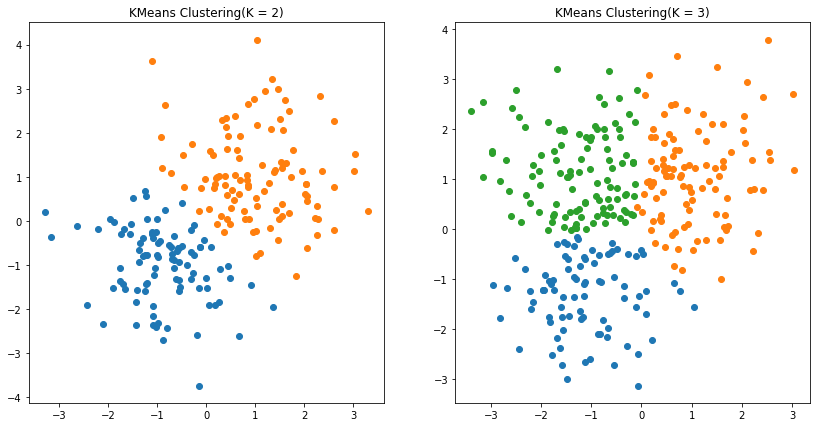

In [3]:
X2 = make_data(cluster=2)
X3 = make_data(cluster=3) 
km2 = KMeans(K = 2)
km3 = KMeans(K = 3)
cluster2,_ = km2.fit(X2) 
cluster3,_ = km3.fit(X3)

fig,ax = plt.subplots(1,2,figsize=(14,7)) 
ax[0].scatter(X2[cluster2 == 0,0],X2[cluster2 == 0,1])
ax[0].scatter(X2[cluster2 == 1,0],X2[cluster2 == 1,1])
ax[0].set_title("KMeans Clustering(K = 2)")

ax[1].scatter(X3[cluster3 == 0,0],X3[cluster3 == 0,1])
ax[1].scatter(X3[cluster3 == 1,0],X3[cluster3 == 1,1])
ax[1].scatter(X3[cluster3 == 2,0],X3[cluster3 == 2,1])
ax[1].set_title("KMeans Clustering(K = 3)")
plt.show()

# Ancestral Sampling

In [4]:
def gm_sampling(n=100,pi=None,mu=None,sigma=None):
    if pi is None:
        assert mu is None and sigma is None 
        pi = np.ones((3)) / 3 
        mu = np.array([
            np.array([1,1]),
            np.array([-1,-1]),
            np.array([1,-1])
        ])
        sigma = np.array([np.eye(2) for _ in range(3)])
    
    z = np.random.multinomial(1,pi,size=n) 
    X = np.zeros((n,mu.shape[1])) 
    N = np.sum(z,axis = 0)
    for k in range(pi.shape[0]):
        n_k = N[k]
        X[z[:,k] == 1,:] = np.random.multivariate_normal(mu[k],sigma[k],n_k)
    return X 

In [12]:
pi = np.array([1/3,1/3,1/3]) 

mu = np.array([
    [-4.0,-0.5],
    [0,0],
    [4.0,0.5]
])

sigma = np.array([
    [[1,0.8],[0.8,1]],
    [[1,-0.8],[-0.8,1]], 
    [[1,0.8],[0.8,1]]
])

# EM algorithm for Gaussian Mixture 

In [13]:
def calc_responsibility(X,pi,mu,sigma):
    # calcurate responsibility 
    
    N = X.shape[0] 
    M = X.shape[1] 
    K = pi.shape[0]

    tmp = X.reshape(N,1,M) - mu.reshape(1,K,M)
    normalize_and_pi = (2*np.pi)**(-M/2) * np.linalg.det(sigma)**(-0.5) * pi 
    gauss = normalize_and_pi * np.exp( -0.5 * tmp.reshape(N,K,1,M)@sigma.reshape(1,K,M,M)@tmp.reshape(N,K,M,1)).reshape(N,K) 
    gamma = gauss / gauss.sum(axis = 1,keepdims=True) 
    return gamma 

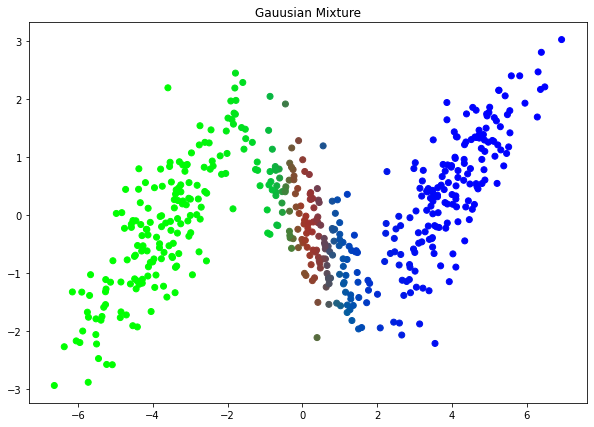

In [14]:
X = gm_sampling(n = 500,pi=pi,mu=mu,sigma=sigma)

km = KMeans(K = 3) 
cluster,_ = km.fit(X)
l2o = LabelToOnehot() 

init_gamma = l2o.fit_transform(cluster) 
init_pi = init_gamma.mean(axis = 0)
init_mu = np.array([X[cluster == 0].mean(axis = 0),X[cluster == 1].mean(axis = 0),X[cluster == 2].mean(axis = 0)])
init_sigma = [] 
for i in range(3):
    tmp = X[cluster == i] - init_mu[i]
    init_sigma.append(tmp.T@tmp)
init_sigma = np.concatenate(init_sigma)

# gm fit 
gm = GaussianMixture(K = 3,max_iter=300)
pi,mu,sigma = gm.fit(X,init_gamma,init_pi,init_mu,init_sigma) 
responsibility = calc_responsibility(X,pi,mu,sigma) 

# plot 
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.scatter(X[:,0],X[:,1],c=responsibility)
ax.set_title("Gauusian Mixture")
plt.show()